In [2]:
import numpy as np

from matplotlib import pyplot as plot, colors
%matplotlib inline

from mpl_toolkits import basemap
from netCDF4 import Dataset, num2date

In [32]:
# Input file and data visualization settings
file = './results/modis/chla/A201401_CHL_NW_month.nc'
varname = 'chlor_a'
font_size = 20
cmin, cmax = -2, 2
# for CHL we use lognorm
norm = colors.LogNorm(cmin, cmax)
# update the size of figure labels
plot.rcParams.update({'font.size': font_size})

In [23]:
# Assuming these are the coordinates you want to crop to
lat_min_crop, lat_max_crop = 35.124, 35.34  # Update these values as needed
lon_min_crop, lon_max_crop = 139.115, 139.62  # Update these values as needed

In [33]:
# Read the dataset and geo-ref data
with Dataset(file, 'r') as nc:
    sds = nc[varname][:] # the output is a numpy masked array
    sds = np.ma.squeeze(sds)  # Remove singleton dimensions if present
    print("Shape of 'sds' before cropping:", sds.shape)  # Add this line to check the shape

    sds = np.ma.squeeze(sds) # remove singleton dimensions
    label = nc[varname].units.replace('^-3', '$^{-3}$')
    lat = nc['lat'][:]
    lon = nc['lon'][:]
    
    # Find indices for cropping
    lat_inds = np.where((lat >= lat_min_crop) & (lat <= lat_max_crop))[0]
    lon_inds = np.where((lon >= lon_min_crop) & (lon <= lon_max_crop))[0]
    print(sds)
    # Crop data
        # Now add a check to ensure the indices are within the bounds of the array
    if lat_inds.size > 0 and lon_inds.size > 0:
        # Adjust the slicing based on the actual dimensions of sds
        sds_cropped = sds[lat_inds, :][:, lon_inds]  # This is the updated line for a 2D array
        lat_cropped = lat[lat_inds]
        lon_cropped = lon[lon_inds]
    else:
        print("No data within specified crop bounds.")
        
    # sds_cropped = sds[:, lat_inds, :][:, :, lon_inds]  # Assuming sds has a shape of [time, lat, lon]
    lat_cropped = lat[lat_inds]
    lon_cropped = lon[lon_inds]

    print(np.ma.mean(sds_cropped))
    
    time = num2date(nc['time'][:], 
                    units=nc['time'].units,
                    calendar=nc['time'].calendar)
    label = nc[varname].long_name.split(',')[0] + f' [{label}]'

Shape of 'sds' before cropping: (2219, 2250)
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... 0.19856072962284088 0.19579686224460602
  0.18666794896125793]
 [-- -- -- ... 0.1958054155111313 0.19545036554336548 0.18931502103805542]
 [-- -- -- ... 0.2002500742673874 0.20224280655384064 0.1880737692117691]]
0.37368511480126676


In [27]:

from matplotlib.colors import LinearSegmentedColormap

# Define your color list in hex
hex_colors = [
    '#3500a8', '#0800ba', '#003fd6',
    '#00aca9', '#77f800', '#ff8800',
    '#b30000', '#920000', '#880000'
]

# Convert hex color list to RGB
rgb_colors = [colors.hex2color(color) for color in hex_colors]

runnign
1.0713296 -2.6166573


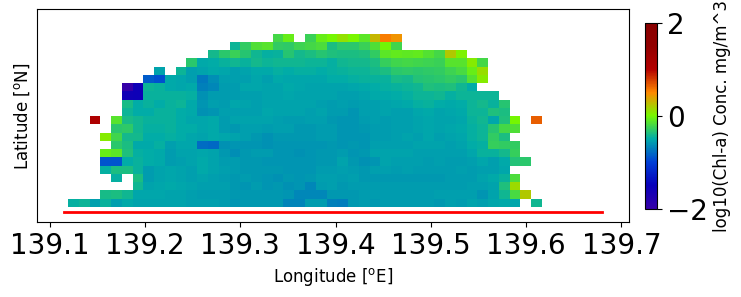

In [34]:
# Visualisation with basemap
print("runnign")
if len(lon_cropped.shape) == 1:
    lon_cropped, lat_cropped = np.meshgrid(lon_cropped, lat_cropped)
lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
m = basemap.Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                    urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                    lon_0=lon_0, lat_0=lat_0, projection='merc')

# print(sds_cropped)
sds_cropped_log = np.ma.masked_less_equal(sds_cropped, 0)  # Mask non-positive values
sds_cropped_log = np.ma.log10(sds_cropped_log)  # Apply log10 to the data
# print(sds_cropped_log)

# Visualisation without basemap
# Adjust figsize to change the aspect ratio
fig, ax = plot.subplots(figsize=(8, 6))  # Adjust the width and height to better suit your data aspect ratio

# figure bounds
extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]

# Land mask
mask = np.where(~sds_cropped_log.mask, np.nan, 0)
ax.imshow(mask, cmap='gray', vmin=-2, vmax=0, extent=extent)

# Create a colormap object
custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

print(sds_cropped_log.max(), sds_cropped_log.min())
# Data 
# We no longer use LogNorm here since we've manually applied log10
# ims = ax.imshow(sds_cropped_log, cmap='jet', extent=extent)
ims = ax.imshow(sds_cropped_log,vmin=cmin, vmax=cmax,  cmap=custom_colormap, extent=extent)

# # Figure labels
ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
ax.set_yticks(range(int(np.ceil(lat_cropped.min())), int(np.ceil(lat_cropped.max())) + 1, 1))
# ax.set_title(time[0].strftime('%b %Y'))

# # Colourbar
cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.02, pad=0.025, aspect=15)
cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")

# Small Sagami Bay
lat_min, lat_max = 35.124, 35.34
lon_min, lon_max = 139.115, 139.68

# # Draw a rectangle around the region of interest
plot.plot([lon_min, lon_max], [lat_min, lat_min], color='r', lw=2)


# # colourbar with axes set to match figure size
# cax = plot.axes([0.8, 0.1, 0.03, 0.7]) # setup colorbar axes
# cb = plot.colorbar(pm, label=label, cax=cax, format='%g') # draw colorbar
# cb.ax.tick_params(width=2, length=4)
# save


